# Deep learning and Post-processing of Film3

In [1]:
import os
if not os.path.exists("./training_set_processed"):
    os.mkdir("./training_set_processed")
if not os.path.exists("./ML_result"):
    os.mkdir("./ML_result")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from tqdm import tqdm
from math import pi

def stokes_from_alphabeta(alpha,beta):
    alpha=alpha/180*pi
    beta=beta/180*pi
    result=np.zeros(3,dtype=np.float32)
    result[0]=0.5*(np.cos(4*alpha-4*beta)+np.cos(4*alpha))
    result[1]=0.5*(np.sin(4*alpha)-np.sin(4*alpha-4*beta))
    result[2]=-np.sin(4*alpha-2*beta)
    return result



n_alpha=36
n_beta=36

alpha_array=np.linspace(0,90,n_alpha+1)[:-1]
beta_array=np.linspace(0,180,n_beta+1)[:-1]
ori_x=np.zeros((n_alpha,n_beta,40*40),dtype=np.uint16)
ori_y=np.zeros((n_alpha,n_beta,3),dtype=np.float32)

for i in tqdm(range(n_alpha)):
    cur_npz=np.load("./training_set/alpha%.2f.npz"%alpha_array[i])["arr_0"]
    for j in range(n_beta):
        ori_x[i,j]=zoom(cur_npz[j],(40/cur_npz[j].shape[0],40/cur_npz[j].shape[1])).reshape(-1)
        ori_y[i,j]=stokes_from_alphabeta(alpha_array[i],beta_array[j])

ori_x=ori_x.astype(np.float32)
train_mean=np.mean(np.mean(ori_x,axis=0),axis=0)
ori_x=ori_x/train_mean-1
#train_std=np.std(np.std(ori_x,axis=0),axis=0)
train_std=1
ori_x=ori_x/train_std

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [01:06<00:00,  1.85s/it]


In [3]:
def insert_img(x_list,y_list,n_each):
    # x_list,y_list: 1D list in [ori,down,right,downright]
    x_result=np.zeros((n_each+2,n_each+2,x_list[0].shape[0]),dtype=np.float32)
    y_result=np.zeros((n_each+2,n_each+2,y_list[0].shape[0]),dtype=np.float32)
    
    x_result[0,0]=x_list[0]
    x_result[-1,0]=x_list[1]
    x_result[0,-1]=x_list[2]
    x_result[-1,-1]=x_list[3]
    y_result[0,0]=y_list[0]
    y_result[-1,0]=y_list[1]
    y_result[0,-1]=y_list[2]
    y_result[-1,-1]=y_list[3]
    
    for i in range(1,n_each+1):
        x_result[0,i]=x_result[0,0]+(x_result[0,-1]-x_result[0,0])/(n_each+1)*i
        x_result[-1,i]=x_result[0,0]+(x_result[0,-1]-x_result[0,0])/(n_each+1)*i
        y_result[0,i]=y_result[0,0]+(y_result[0,-1]-y_result[0,0])/(n_each+1)*i
        y_result[-1,i]=y_result[0,0]+(y_result[0,-1]-y_result[0,0])/(n_each+1)*i
    for i in range(x_result.shape[1]-1):
        for j in range(1,n_each+1):
            x_result[j,i]=x_result[0,i]+(x_result[-1,i]-x_result[0,i])/(n_each+1)*j
            y_result[j,i]=y_result[0,i]+(y_result[-1,i]-y_result[0,i])/(n_each+1)*j
    return x_result[:-1,:-1],y_result[:-1,:-1]

In [4]:
for i in tqdm(range(n_alpha)):
    for j in range(n_beta):
        x_list=[ori_x[i,j]]
        y_list=[ori_y[i,j]]
        if i==n_alpha-1:
            alpha_plus=0
        else:
            alpha_plus=i+1
        if j==n_beta-1:
            beta_plus=0
        else:
            beta_plus=j+1
        x_list.append(ori_x[alpha_plus,j])
        y_list.append(ori_y[alpha_plus,j])
        x_list.append(ori_x[i,beta_plus])
        y_list.append(ori_y[i,beta_plus])
        x_list.append(ori_x[alpha_plus,beta_plus])
        y_list.append(ori_y[alpha_plus,beta_plus])
        
        x_result,y_result=insert_img(x_list,y_list,0)
        np.savez("./training_set_processed/alpha%.2f_beta%.2f.npz"%(alpha_array[i],beta_array[j]),x_result,y_result)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 77.37it/s]


In [5]:
cur_npz=np.load("./test_set/data.npz")["arr_0"]
ori_x=np.zeros((cur_npz.shape[0],40*40),dtype=np.uint16)
ori_y=np.zeros((cur_npz.shape[0],3),dtype=np.float32)
fo=np.load("./test_set/alphabeta.npz")
cur_alpha=fo["arr_0"]
cur_beta=fo["arr_1"]
for i in tqdm(range(cur_npz.shape[0])):
    ori_x[i]=zoom(cur_npz[i],(40/cur_npz[i].shape[0],40/cur_npz[i].shape[1])).reshape(-1)
    ori_y[i]=stokes_from_alphabeta(cur_alpha[i],cur_beta[i])

ori_x=ori_x.astype(np.float32)
ori_x=ori_x/train_mean-1
ori_x=ori_x/train_std

np.savez("./test_set/data_processed.npz",ori_x,ori_y)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.79it/s]


In [6]:
cur_npz=np.load("./val_set/data.npz")["arr_0"]
ori_x=np.zeros((cur_npz.shape[0],40*40),dtype=np.uint16)
ori_y=np.zeros((cur_npz.shape[0],3),dtype=np.float32)
fo=np.load("./val_set/alphabeta.npz")
cur_alpha=fo["arr_0"]
cur_beta=fo["arr_1"]
for i in tqdm(range(cur_npz.shape[0])):
    ori_x[i]=zoom(cur_npz[i],(40/cur_npz[i].shape[0],40/cur_npz[i].shape[1])).reshape(-1)
    ori_y[i]=stokes_from_alphabeta(cur_alpha[i],cur_beta[i])

ori_x=ori_x.astype(np.float32)
ori_x=ori_x/train_mean-1
ori_x=ori_x/train_std

np.savez("./val_set/data_processed.npz",ori_x,ori_y)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.01it/s]


# CNN

In [7]:
import torch
print("Using torch", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using torch 2.0.1+cu118
Using device: cuda


In [8]:
import numpy as np
from tqdm import tqdm

n_alpha=36
n_beta=36
n_insert=0
alpha_array=np.linspace(0,90,n_alpha+1)[:-1]
beta_array=np.linspace(0,180,n_beta+1)[:-1]

flat_x=np.zeros((n_alpha*(n_insert+1),n_beta*(n_insert+1),40*40),dtype=np.float32)
flat_y=np.zeros((n_alpha*(n_insert+1),n_beta*(n_insert+1),3),dtype=np.float32)

for i in tqdm(range(n_alpha)):
    for j in range(n_beta):
        cur_file=np.load("./training_set_processed/alpha%.2f_beta%.2f.npz"%(alpha_array[i],beta_array[j]))
        flat_x[i*(n_insert+1):(i+1)*(n_insert+1),j*(n_insert+1):(j+1)*(n_insert+1)]=cur_file["arr_0"]
        flat_y[i*(n_insert+1):(i+1)*(n_insert+1),j*(n_insert+1):(j+1)*(n_insert+1)]=cur_file["arr_1"]
flat_x=flat_x.reshape(-1,40*40)
flat_y=flat_y.reshape(-1,3)

x_train=torch.from_numpy(flat_x.reshape(-1,1,40,40)).to(device)
y_train=torch.from_numpy(flat_y).to(device)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:14<00:00,  2.44it/s]


In [9]:
fo=np.load("./val_set/data_processed.npz")
x_val=torch.from_numpy(fo["arr_0"].reshape(-1,1,40,40)).to(device)
y_val=torch.from_numpy(fo["arr_1"]).to(device)

fo=np.load("./test_set/data_processed.npz")
x_test=torch.from_numpy(fo["arr_0"].reshape(-1,1,40,40)).to(device)
y_test=torch.from_numpy(fo["arr_1"]).to(device)

In [10]:
import torch.nn as nn

class Simple_CNN(nn.Module):
    def __init__(self,p):
        super().__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(1,16,5,1,2),                              
            nn.ReLU(),            
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16,32,3,1,1),     
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32,64,3,1,1),     
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                
        )
        self.mlp = nn.Sequential(
            nn.Dropout(p=p),
            nn.Linear(5*5*64,1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024,3),
        )
        
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        y = self.conv3(y)
        y = y.view(y.size(0), -1)       
        y = self.mlp(y)
        return y

In [11]:
def train(model,X,y,optimizer,loss_fn,batchsize=650):
    idx=np.arange(X.shape[0])
    np.random.shuffle(idx)
    
    epoch_loss = 0
    model.train()
    for i in range(0,X.shape[0],batchsize):
        if i+batchsize>=X.shape[0]:
            cur_idx=idx[i:]
        else:
            cur_idx=idx[i:i+batchsize]
            
        optimizer.zero_grad()
        y_pred = model(X[cur_idx])
        loss = loss_fn(y_pred, y[cur_idx])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()*cur_idx.shape[0]
        return epoch_loss/X.shape[0]
    
def evaluate(model,X,y,loss_fn,batchsize=5000):
    epoch_loss = 0
    separate_loss=np.zeros(3,dtype=np.float32)
    model.eval()
    with torch.no_grad():
        for i in range(0,X.shape[0],batchsize):
            i_start=i
            if i+batchsize>=X.shape[0]:
                i_end=X.shape[0]-1
            else:
                i_end=i+batchsize
                
            y_pred=model(X[i_start:i_end])
            loss = loss_fn(y_pred, y[i_start:i_end])
            epoch_loss += loss.item()*(i_end-i_start)
            separate_loss += torch.sum(torch.square(y_pred-y[i_start:i_end]),dim=0).to("cpu").numpy()
            
        epoch_loss=epoch_loss/X.shape[0]
        separate_loss=separate_loss/X.shape[0]
    return epoch_loss,separate_loss

In [12]:
from torch.nn import MSELoss
from torch.optim import Adam
from tqdm import tqdm 
import pandas as pd

def run_cnn_exp(task_name,p,
                    seed_list=[324,715,10086],n_epoch=10000,save_dir="./ML_result/"):
    score=[]
    print("Running %s"%task_name)
    for seed in seed_list:
        torch.manual_seed(seed)
        model=Simple_CNN(p)
        model = model.to(device)
        loss_fn=MSELoss()
        optimizer=Adam(model.parameters(),lr=0.001)
        result=np.zeros((n_epoch,6),dtype=np.float32)
        
        first_stage=round(n_epoch*0.5)
        for i in tqdm(range(first_stage)):
            result[i,0]=train(model,x_train,y_train,optimizer,loss_fn)
            result[i,1],_=evaluate(model,x_val,y_val,loss_fn)
            result[i,2],result[i,3:]=evaluate(model,x_test,y_test,loss_fn)
        
        torch.save(model,save_dir+task_name+"_seed%d"%seed+".pt")
        #optimizer.param_groups[0]['lr'] = 0.0005
        for i in tqdm(range(first_stage,n_epoch)):
            result[i,0]=train(model,x_train,y_train,optimizer,loss_fn)
            result[i,1],_=evaluate(model,x_val,y_val,loss_fn)
            result[i,2],result[i,3:]=evaluate(model,x_test,y_test,loss_fn)
            if np.min(result[:i,1])>result[i,1]:
                torch.save(model,save_dir+task_name+"_seed%d"%seed+".pt")
        
        best_idx=np.argmin(result[:,1])
        score.append(result[best_idx,2])
        result=pd.DataFrame(result,columns=["train_loss","validation_loss","test_loss","S1_loss","S2_loss","S3_loss"])
        save_filename=save_dir+task_name+"_seed%d"%seed+".csv"
        result.to_csv(save_filename,index=False)
    return score

In [13]:
run_cnn_exp("CNN_p=0.001",0.001)

Running CNN_p=0.001


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:18<00:00, 35.99it/s]


[0.00018704763, 0.00018105387, 0.0001847715]

In [14]:
seed_list=[324,715,10086]
mse_result=np.zeros((len(seed_list),3))
mae_result=np.zeros((len(seed_list),3))
for i in range(len(seed_list)):
    table=pd.read_csv("./ML_result/CNN_p=0.001_seed%d.csv"%seed_list[i])
    best_idx=np.argmin(table["validation_loss"].values)
    mse_result[i]=table.iloc[best_idx,3:].values
    model=torch.load("./ML_result/CNN_p=0.001_seed%d.pt"%seed_list[i])
    model=model.to(device)
    with torch.no_grad():
        y_pred=model(x_test).to("cpu").numpy()
        y_real=y_test.to("cpu").numpy()
    mae_result[i]=np.mean(np.abs(y_pred-y_real),axis=0)
print(mse_result)
print("mean MSE:",np.mean(mse_result,axis=0))
print("std MSE:",np.std(mse_result,axis=0,ddof=1))
print(mae_result)
print("mean MAE:",np.mean(mae_result,axis=0))
print("std MAE:",np.std(mae_result,axis=0,ddof=1))

[[0.00012855 0.00029265 0.00013994]
 [0.00015658 0.00027261 0.00011397]
 [0.0001918  0.00023591 0.00012661]]
mean MSE: [0.00015898 0.00026706 0.00012684]
std MSE: [3.16894958e-05 2.87748843e-05 1.29871941e-05]
[[0.00840107 0.01298687 0.0085379 ]
 [0.00880011 0.01141003 0.00817016]
 [0.00982434 0.01226845 0.00772861]]
mean MAE: [0.00900851 0.01222178 0.00814556]
std MAE: [0.00073416 0.00078946 0.00040521]


[0.00012855 0.00029265 0.00013994] 0.00016885382


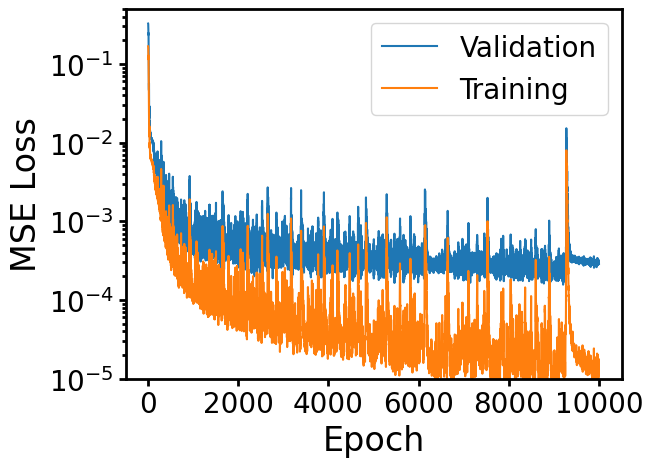

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

table=pd.read_csv("./ML_result/CNN_p=0.001_seed324.csv")
best_idx=np.argmin(table["validation_loss"].values)
print(table.iloc[best_idx,3:].values,table["test_loss"].min())

plt.plot(np.arange(table.shape[0]),table["validation_loss"],label="Validation")
plt.plot(np.arange(table.shape[0])-1,table["train_loss"],label="Training")




plt.yscale("log")
plt.ylim(0.00001,0.5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel("Epoch",fontsize=24)
plt.ylabel("MSE Loss",fontsize=24)
plt.legend(fontsize=20)

bwidth=2
plt.tick_params(which="major",width=bwidth,length=5)
plt.tick_params(which="minor",width=bwidth,length=3)
tk=plt.gca()
tk.spines["bottom"].set_linewidth(bwidth)
tk.spines["top"].set_linewidth(bwidth)
tk.spines["left"].set_linewidth(bwidth)
tk.spines["right"].set_linewidth(bwidth)
plt.show()

[0.01304337 0.02063105 0.0079338 ]


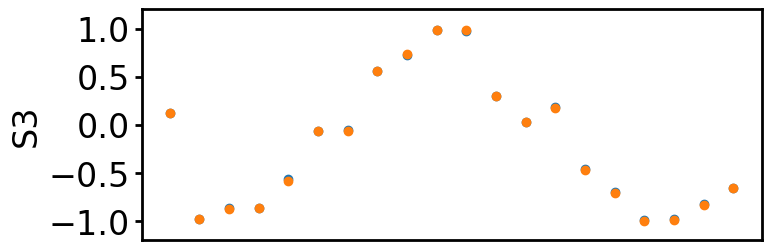

In [29]:
plt.figure(figsize=(8, 3))

model=torch.load("./ML_result/CNN_p=0.001_seed1222.pt")
model=model.to(device)
with torch.no_grad():
    y_pred=model(x_test).to("cpu").numpy()
    y_real=y_test.to("cpu").numpy()
print(np.mean(np.abs(y_pred-y_real),axis=0))
x=np.arange(20)
plt.scatter(x,y_real[:20,2],label="Ground truth")
plt.scatter(x,y_pred[:20,2],label="Prediction")

plt.ylim(-1.2,1.2)
plt.xticks([])
plt.yticks(fontsize=24)
plt.ylabel("S3",fontsize=24)
#plt.legend(fontsize=20)

bwidth=2
plt.tick_params(which="major",width=bwidth,length=5)
plt.tick_params(which="minor",width=bwidth,length=3)
tk=plt.gca()
tk.spines["bottom"].set_linewidth(bwidth)
tk.spines["top"].set_linewidth(bwidth)
tk.spines["left"].set_linewidth(bwidth)
tk.spines["right"].set_linewidth(bwidth)
plt.show()